In [1]:
# %matplotlib
from pyGCodeDecode.junction_handling import *
from pyGCodeDecode.utils import position
from pyGCodeDecode.state import state
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rotate_pos(pos: position, alpha):
    alpha = math.radians(alpha)
    pos_v = np.array(pos.get_vec()[:2])
    rot_M = np.array([[math.cos(alpha), -math.sin(alpha)], [math.sin(alpha), math.cos(alpha)]])
    new_pos = np.matmul(rot_M, pos_v)
    return new_pos

In [3]:
def initialize_dummy_states(p_acc=50, jerk=10, speed=100):
    settings = state.p_settings(p_acc=p_acc, jerk=jerk, vX=100, vY=100, vZ=100, vE=100, speed=speed)
    stateA = state(state_p_settings=settings)
    stateB = state(state_p_settings=settings)
    stateC = state(state_p_settings=settings)

    stateA.next_state = stateB
    stateB.prev_state = stateA
    stateB.next_state = stateC
    stateC.prev_state = stateB
    return stateA, stateB, stateC

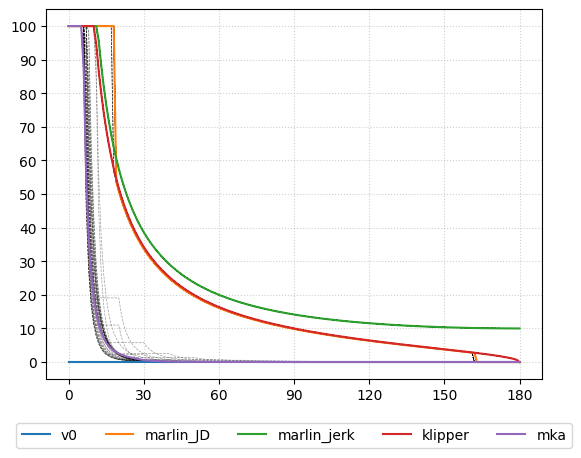

In [4]:
stateA, stateB, stateC = initialize_dummy_states(p_acc=1250, jerk=10, speed=100)

for alpha in range(0, 361, 5):  # rotate all positions in space to capture axis dependant anomalies
    # reset positions
    stateA.state_position = position(0, 0, 0, 0)
    stateB.state_position = position(50, 0, 0, 0)

    stateA.state_position = position(*rotate_pos(stateA.state_position, alpha), 0, 0)
    stateB.state_position = position(*rotate_pos(stateB.state_position, alpha), 0, 0)

    angles = range(0, 181, 1)  # angle test range
    result = []

    for angle in angles:
        coordXY = [
            math.cos(math.radians(angle)) * 50 + 50,
            math.sin(math.radians(angle)) * 50,
        ]  # calc new position based on angle
        stateC.state_position = position(*coordXY, 0, 0)
        stateC.state_position = position(*rotate_pos(stateC.state_position, alpha), 0, 0)

        v0 = junction_handling(state_A=stateA, state_B=stateB).get_junction_vel()
        v1 = junction_handling_marlin(state_A=stateA, state_B=stateB).get_junction_vel()
        v2 = junction_handling_marlin_jerk(state_A=stateA, state_B=stateB).get_junction_vel()
        v3 = junction_handling_klipper(state_A=stateA, state_B=stateB).get_junction_vel()
        v4 = junction_handling_MKA(state_A=stateA, state_B=stateB).get_junction_vel()
        result.append([angle, v0, v1, v2, v3, v4])

    result = np.reshape(result, (-1, 6))

    if alpha == 0:
        plt.plot(result[:, 0], result[:, 1:], label=["v0", "marlin_JD", "marlin_jerk", "klipper", "mka"], zorder=10)
    else:
        plt.plot(result[:, 0], result[:, 1:], alpha=0.2, c="black", zorder=0, linestyle="--", lw=0.5)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.grid(visible=True, which="major", axis="both", alpha=0.6, linestyle="dotted")
plt.xticks(range(0, 181, 30))
plt.yticks(range(0, 101, 10))

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


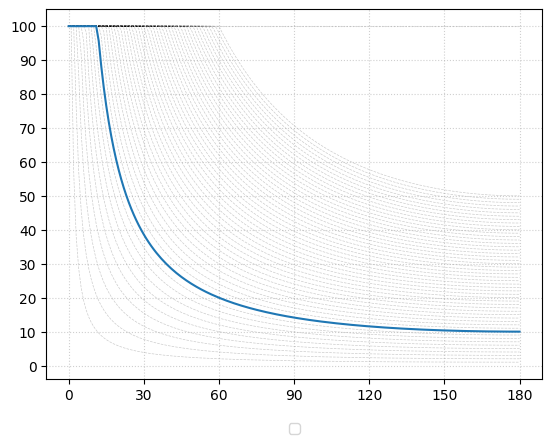

In [27]:
stateA, stateB, stateC = initialize_dummy_states(p_acc=1250, jerk=10, speed=100)
move_dist = 100

for jerk in range(0, 51, 1):  # rotate all positions in space to capture axis dependant anomalies
    # reset positions
    stateA.state_position = position(0, 0, 0, 0)
    stateB.state_position = position(move_dist, 0, 0, 0)

    stateA.state_p_settings.jerk = jerk
    stateB.state_p_settings.jerk = jerk
    stateC.state_p_settings.jerk = jerk

    angles = range(0, 181, 1)  # angle test range
    result = []

    for angle in angles:
        coordXY = [
            math.cos(math.radians(angle)) * move_dist + move_dist,
            math.sin(math.radians(angle)) * move_dist,
        ]  # calc new position based on angle
        stateC.state_position = position(*coordXY, 0, 0)

        v0 = junction_handling(state_A=stateA, state_B=stateB).get_junction_vel()
        v1 = junction_handling_marlin(state_A=stateA, state_B=stateB).get_junction_vel()
        v2 = junction_handling_marlin_jerk(state_A=stateA, state_B=stateB).get_junction_vel()
        v3 = junction_handling_klipper(state_A=stateA, state_B=stateB).get_junction_vel()
        v4 = junction_handling_MKA(state_A=stateA, state_B=stateB).get_junction_vel()
        result.append([angle, v0, v1, v2, v3, v4])

    result = np.reshape(result, (-1, 6))
    select = 3
    if jerk == 10:
        # plt.plot(result[:, 0], result[:, 1:], label=["v0", "marlin_JD", "marlin_jerk", "klipper", "mka"], zorder=10)
        plt.plot(result[:, 0], result[:, select], label="", zorder=10)
    else:
        plt.plot(result[:, 0], result[:, select], alpha=0.2, zorder=0, c="black", linestyle="--", lw=0.5)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.grid(visible=True, which="major", axis="both", alpha=0.6, linestyle="dotted")
plt.xticks(range(0, 181, 30))
plt.yticks(range(0, 101, 10))

plt.show()

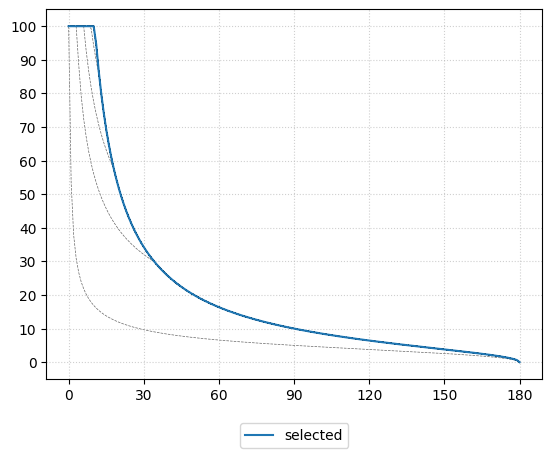

In [26]:
stateA, stateB, stateC = initialize_dummy_states(p_acc=1250, jerk=10, speed=100)
move_dist = 50

for p_acc in range(1, 1251, 10):  # rotate all positions in space to capture axis dependant anomalies
    # reset positions
    stateA.state_position = position(0, 0, 0, 0)
    stateB.state_position = position(move_dist, 0, 0, 0)

    stateA.state_p_settings.p_acc = p_acc
    stateB.state_p_settings.p_acc = p_acc
    stateC.state_p_settings.p_acc = p_acc

    angles = range(0, 181, 1)  # angle test range
    result = []

    for angle in angles:
        coordXY = [
            math.cos(math.radians(angle)) * move_dist + move_dist,
            math.sin(math.radians(angle)) * move_dist,
        ]  # calc new position based on angle
        stateC.state_position = position(*coordXY, 0, 0)

        v0 = junction_handling(state_A=stateA, state_B=stateB).get_junction_vel()
        v1 = junction_handling_marlin(state_A=stateA, state_B=stateB).get_junction_vel()
        v2 = junction_handling_marlin_jerk(state_A=stateA, state_B=stateB).get_junction_vel()
        v3 = junction_handling_klipper(state_A=stateA, state_B=stateB).get_junction_vel()
        v4 = junction_handling_MKA(state_A=stateA, state_B=stateB).get_junction_vel()
        result.append([angle, v0, v1, v2, v3, v4])

    result = np.reshape(result, (-1, 6))
    select = 4

    if p_acc == 101:
        # plt.plot(result[:, 0], result[:, 1:], label=["v0", "marlin_JD", "marlin_jerk", "klipper", "mka"], zorder=10)
        plt.plot(result[:, 0], result[:, select], label="selected", zorder=10)
    else:
        # plt.plot(result[:, 0], result[:, 1:], alpha=0.6, zorder=0, c="black", linestyle="--", lw=0.5)
        plt.plot(result[:, 0], result[:, select], alpha=0.6, zorder=0, c="black", linestyle="--", lw=0.5)


plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.grid(visible=True, which="major", axis="both", alpha=0.6, linestyle="dotted")
plt.xticks(range(0, 181, 30))
plt.yticks(range(0, 101, 10))

plt.show()